In [2]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt

In [3]:
model = YOLO("plate.pt")

In [4]:
# Path to your test image (change this to your own image path)
image_path = "1.jpg"

# Run detection
results = model(image_path, conf=0.7)  # confidence threshold 50%

# results[0] contains detections for the first (and only) image
results[0].show()   # OpenCV popup (if supported)


image 1/1 c:\Users\tristhan\Documents\GITHUB_ESP32\dspCPE4A2526\Activity9\1.jpg: 640x480 1 Plate-Number, 474.3ms
Speed: 7.5ms preprocess, 474.3ms inference, 13.3ms postprocess per image at shape (1, 3, 640, 480)


In [34]:
pip install  pytesseract

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


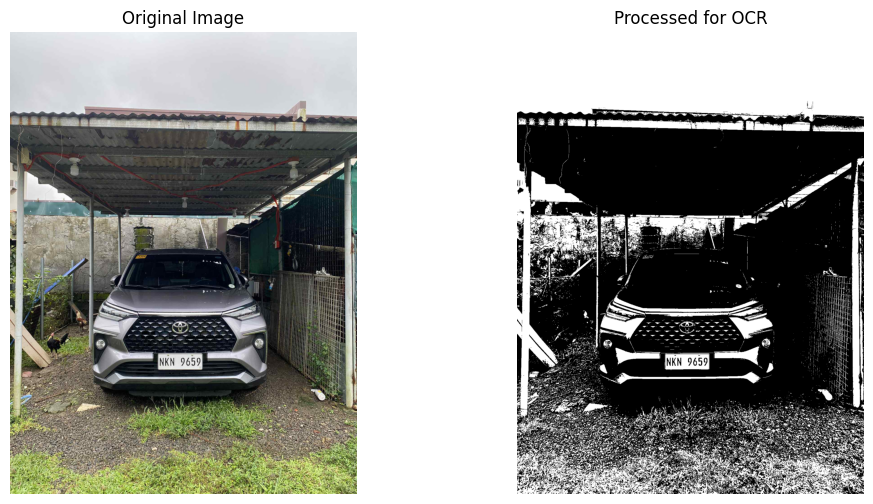

Extracted Text:
 pilin tilling a. ee cnctiindtiiadind
rr ew i iieadiind
Steet ain ~~~ ow

cwvw~wT Ss we wwe eT




In [5]:
import cv2
import pytesseract
from matplotlib import pyplot as plt

# --- OPTIONAL: If tesseract is not in PATH, set the path manually ---
# For Windows, uncomment and adjust:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def ocr_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Morphological noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # OCR with Tesseract
    text = pytesseract.image_to_string(cleaned)

    # Show original and processed image inline (Jupyter)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(cleaned, cmap="gray")
    axs[1].set_title("Processed for OCR")
    axs[1].axis("off")

    plt.show()

    return text


# Example usage
text_output = ocr_image("1.jpg")
print("Extracted Text:\n", text_output)


image 1/1 c:\Users\tristhan\Documents\GITHUB_ESP32\dspCPE4A2526\Activity9\1.jpg: 640x480 1 Plate-Number, 422.3ms
Speed: 2.0ms preprocess, 422.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


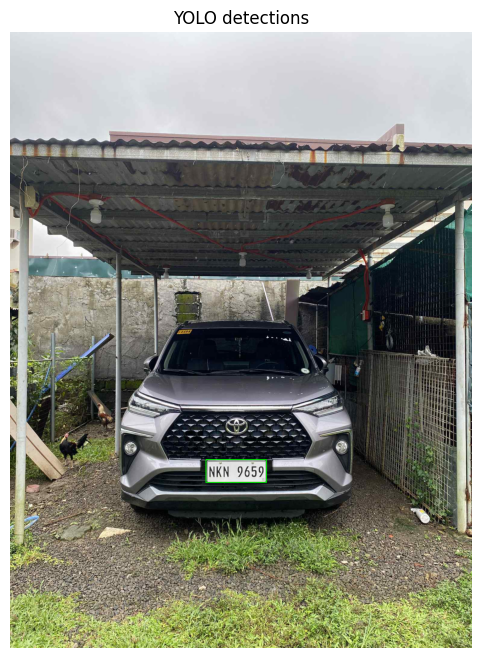

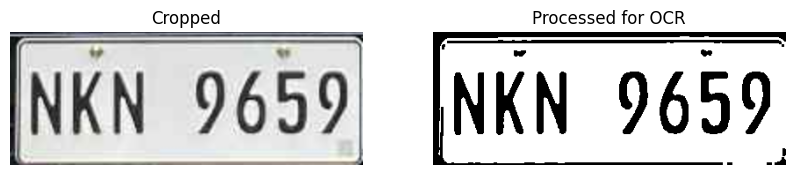

Detected Plate Numbers:
1. NKN9659


In [ ]:
import cv2
import pytesseract
import re
from matplotlib import pyplot as plt

#YOLO detection 
image_path = "1.jpg"
results = model(image_path, conf=0.7)  
boxes = results[0].boxes
img = cv2.imread(image_path)
img_draw = img.copy()

plate_texts = []

#Draw bounding boxes 
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show YOLO result (boxes only)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("YOLO detections")
plt.show()

#CROP and OCR
for idx, box in enumerate(boxes, start=1):
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    plate = img[y1:y2, x1:x2]

    if plate.size == 0:
        print(f"Plate {idx}: empty crop (skipped)")
        plate_texts.append("")
        continue

    #Convert to grayscale
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    # Upscale
    h, w = gray.shape
    gray = cv2.resize(gray, (w*2, h*2), interpolation=cv2.INTER_LINEAR)

    #Denoise + blur
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    #threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #Morphological closing to remove small gaps/dots
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # OCR (single word mode, whitelist only letters/numbers)
    config = '--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    raw_text = pytesseract.image_to_string(cleaned, config=config).strip()

    #Remove special characters
    clean_text = re.sub(r'[^A-Z0-9]', '', raw_text.upper())

#plate validate
    if re.match(r'^[A-Z]{3}[0-9]{4}$', clean_text):
        final_plate = clean_text

    elif re.match(r'^[A-Z]{4}[0-9]{4}$', clean_text):
        candidate = clean_text[1:]
        if re.match(r'^[A-Z]{3}[0-9]{4}$', candidate):
            final_plate = candidate
        else:
            final_plate = clean_text

    else:
        final_plate = clean_text

    plate_texts.append(final_plate)

    #SHOW TESSERACT 
    try:
        cropped_enlarged = cv2.resize(plate, (plate.shape[1]*2, plate.shape[0]*2), interpolation=cv2.INTER_LINEAR)
    except Exception:
        cropped_enlarged = plate

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(cv2.cvtColor(cropped_enlarged, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Cropped")
    axs[0].axis("off")

    axs[1].imshow(cleaned, cmap="gray")
    axs[1].set_title("Processed for OCR")
    axs[1].axis("off")
    plt.show()

#RESULTS
print("Detected Plate Numbers:")
for i, t in enumerate(plate_texts, 1):
    print(f"{i}. {t if t else '[No text detected]'}")
